# Setup

In [ ]:
!pip install diffusers==0.18.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.4 MB/s eta 0:00:00


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Training Configuration

In [ ]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    sequence_length = 256  # the generated image resolution
    train_data_paths = ['/content/p8_111.csv']
    filter_class = 1 # open, close, relax
    emgs_cnt = 8 # must be 8 for 2D UNet
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 200
    learning_rate = 4e-4

    noise_scheduler_timesteps = 500

    # these three should be deleted
    noise_type = "normal" # normal
    noise_mean = 0
    noise_std = 1 # if using huggingface pipeline, set it to 1

    gen_batch_size = 9 # gen_batch_size = nrows * ncols
    nrows = 3
    ncols = 3

    model_type = "2DUNet"

    load_model = True
    load_model_path = "./2Dunet-p8-111-ep400"
    train = False
    save_model = False
    save_model_path = "./2Dunet-p8-111-ep200"


config = TrainingConfig()

# Visualization Helper functions

In [ ]:
import matplotlib.pyplot as plt

def visualize_one_emg(data, emg_idx):
  plt.plot(data)
  plt.xlabel('Time')
  plt.ylabel('emg '+str(emg_idx)+' normalized value')
  plt.show()
  plt.close()

def visualize_sample(sample, emgs_cnt, unsqueeze=True):
  if unsqueeze:
    sample = sample.unsqueeze(0)
  print(sample.shape)
  for i in range(emgs_cnt):
    visualize_one_emg(sample[0][i], i)
    pass

From misc_utils

In [ ]:
def plot_emg_chunks(data, nrows=1, ncols=1, vertical_location=None):
    """
    data: (b, t, 8), b = nrows * ncols
    """
    # missing the batch dimension
    if np.ndim(data) == 2:
        data = data[None, ...]
    b, t = data.shape[:2]
    fig, axs = plt.subplots(figsize=(15, 9), nrows=nrows, ncols=ncols, squeeze=False)

    idx = np.array(range(t)) / 100.0
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:brown']

    for i in range(nrows):
        for j in range(ncols):
            for c in range(8):
                y = data[i*ncols+j, :, c]
                axs[i, j].plot(idx, y, label=f'emg{c}', alpha=0.7, color=colors[c])
                if vertical_location is not None:
                    axs[i, j].axvline(x=vertical_location / 100.0, c='b')
                if i*ncols+j == b - 1:
                    axs[i, j].legend()

    plt.xlabel('time (seconds)')
    plt.tight_layout()

    plt.show()

#ChatEMG Dataset

Statistics of p1_111:<br>
Mean of each emg: <br>[0.0451946  0.14492683 0.19912494 0.08450989 0.08813588 0.05372675
 0.04034895 0.07792921] <br>
Std of each emg: <br>
[0.02988127 0.06865422 0.11946873 0.07062819 0.07399311 0.08520439
 0.02091565 0.04998798]

From misc_utils.py

In [ ]:
# copied from misc_utils.py from emg_predictors
def keep_columns(df, tuple_of_columns):
    """
    Given a dataframe, and a tuple of column names, this function will search
    through the dataframe and keep only columns which contain a string from the
    list of the desired columns. All other columns are removed
    """
    if len(tuple_of_columns) >= 1:
        cols = df.columns[df.columns.to_series().str.contains('|'.join(tuple_of_columns))]
        return df[cols]
    return df

def clean_dataframe(df):
    X_df = keep_columns(df, [f'emg'])
    X = X_df.to_numpy()
    y_df = keep_columns(df, ['gt'])
    y = y_df.to_numpy().squeeze()
    return X, y

From ChatEMG Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os
import pathlib
#import misc_utils as mu
import pandas as pd
import numpy as np


class ChatEMGDataset(Dataset):
    def __init__(self, csv_files, filter_class, block_size, normalize=False):
        self.csv_files = csv_files
        self.filter_class = filter_class
        self.block_size = block_size

        #self.data_files_base_directory = \os.path.join(pathlib.Path(__file__).resolve().parent.parent.__str__(), 'collected_data')

        data_list = []
        label_list = []
        for f in self.csv_files:
            #data_path = os.path.join(self.data_files_base_directory, f)
            data_path = f
            df = pd.read_csv(data_path, index_col=0)
            #X, y = mu.clean_dataframe(df)
            X, y = clean_dataframe(df)
            X = np.clip(X, a_min=0, a_max=999)
            X = X / 999 if normalize else X
            data_list.append(X)
            label_list.append(y)

        self.filtered_data_list = data_list
        if self.filter_class is not None:
            self.filtered_data_list = []
            for d, l in zip(data_list, label_list):
                filtered_d = []
                for i in range(len(d)):
                    if l[i] == self.filter_class:
                        filtered_d.append(d[i])
                        if i+1 == len(d) or l[i+1] != self.filter_class:
                            self.filtered_data_list.append(np.array(filtered_d))
                            filtered_d = []

        # now I am removing chunks shorter than block size + 1, because we need to consider y as well
        self.filtered_data_list = [d for d in self.filtered_data_list if len(d) >= (self.block_size + 1)]
        # number of (x, y) pairs in each chunk
        self.filtered_data_lens = [len(d) - self.block_size for d in self.filtered_data_list]

    def __len__(self):
        return sum(self.filtered_data_lens)

    def __getitem__(self, item):
        assert item < self.__len__()

        s = 0
        for i, l in enumerate(self.filtered_data_lens):
            s_new = s + l
            if s <= item < s_new:
                x = self.filtered_data_list[i][item - s: item - s + self.block_size]
                # print(item - s, item - s + self.block_size)
                y = self.filtered_data_list[i][item - s + 1: item - s + self.block_size + 1]
                # print(item - s + 1, item - s + self.block_size + 1)
                # print(i)
                return x, y
            s = s_new

    def sample(self, num):
        # sample some samples without replacement
        idx = np.random.choice(range(self.__len__()), num, replace=False)
        X = []
        Y = []
        for i in idx:
            x, y = self.__getitem__(i)
            X.append(x)
            Y.append(y)
        return np.stack(X), np.stack(Y)

In [ ]:
dataset = ChatEMGDataset(
    csv_files = config.train_data_paths,
    filter_class = config.filter_class,
    block_size = config.sequence_length,
    normalize = True
)
print("sum samples: ", len(dataset))

sum samples:  952


Support function: get_sample, will convert to our shape

In [ ]:
def get_sample(cnt):
  raw_sample = dataset.sample(cnt)
  # convert to np array
  np_sample = np.array(raw_sample) # (2, cnt, block_size, emg_cnt)
  # take only the X component
  x_sample = np_sample[0] # (cnt, block_size, emg_cnt)
  # permute the dimensions
  trans_sample = np.transpose(x_sample, axes=(0,2,1)) #(cnt, emg_cnt, block_size)
  # convert to torch
  sample_tensor = torch.tensor(trans_sample).to(torch.float32)
  return sample_tensor

In [ ]:
import torch

#train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=config.train_batch_size, shuffle=True)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
sample_seqs = np.array(dataset.sample(9))
sample_seqs = sample_seqs[0]
print(sample_seqs.shape)
plot_emg_chunks(sample_seqs, nrows=3, ncols=3)

(9, 256, 8)


# Load an Existing UNet2D Model

In [ ]:
!unzip 2Dunet-p8-111-ep400.zip

Archive:  2Dunet-p8-111-ep400.zip
   creating: 2Dunet-p8-111-ep400/
  inflating: 2Dunet-p8-111-ep400/config.json  
  inflating: 2Dunet-p8-111-ep400/diffusion_pytorch_model.bin  


In [ ]:
from diffusers import UNet2DModel
if config.load_model and config.model_type=="2DUNet":
  model = UNet2DModel.from_pretrained(config.load_model_path).to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


# Create a UNet2DModel

In [ ]:
from diffusers import UNet2DModel

# Create a model
if not config.load_model:
  model = UNet2DModel(
      sample_size=(config.emgs_cnt,config.sequence_length),  # the target image resolution
      in_channels=1,  # the number of input channels, 3 for RGB images
      out_channels=1,  # the number of output channels
      layers_per_block=2,  # how many ResNet layers to use per UNet block
      block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
      down_block_types=(
          "DownBlock2D",  # a regular ResNet downsampling block
          "DownBlock2D",
          "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
          "AttnDownBlock2D",
      ),
      up_block_types=(
          "AttnUpBlock2D",
          "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
          "UpBlock2D",
          "UpBlock2D",  # a regular ResNet upsampling block
      ),
  )
  model.to(device);

use pretrained checkpoints

check the input shape and output shape

In [ ]:
sample_seq = get_sample(1)
print(sample_seq.shape)
sample_for_plot = sample_seq.permute(0,2,1)
plot_emg_chunks(sample_for_plot)
sample_seq = sample_seq.to(device)

if config.model_type=="2DUNet":
  sample_seq = sample_seq.unsqueeze(1)
print("Input shape:", sample_seq.shape)

torch.Size([1, 8, 256])


Input shape: torch.Size([1, 1, 8, 256])


Expect format: (batch, channel, height, width).

In [ ]:
print("Output shape:", model(sample_seq, timestep=0).sample.shape)

Output shape: torch.Size([1, 1, 8, 256])


Check the number of parameters

In [ ]:
sum([p.numel() for p in model.parameters()])

18534017

# Create a Scheduler

Create a noise scheduler & plot its scheduling curve

In [ ]:
from diffusers import DDPMScheduler

# Scheduler: can change parameters such as beta_start=0.001, beta_end=0.004, beta_schedule='squaredcos_cap_v2'
noise_scheduler = DDPMScheduler(num_train_timesteps=config.noise_scheduler_timesteps, beta_schedule='squaredcos_cap_v2')

# plot
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$ sample sequence")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)} noise$")
plt.legend(fontsize="x-large");

Testing add noise

Problem: each sequential segments has very diverse distribution: compare traindata[1000] with traindata[5300]</br>
for sample_idx == 1000, normal noise will corrupt too soon, uniform noise will be better </br>
for sample_idx == 5300, uniform noise not enough, normal noise good

In [ ]:
view_cnt = 1
noise_type = config.noise_type# normal: normal distribution; uniform: uniform distribution within {-1,1}

sample_seq = get_sample(1)
print("Original Sequence from sample: ")
print("mean: ", np.mean(sample_seq.numpy(), axis=2))
visualize_sample(sample_seq[0], view_cnt)

noise = torch.randn(sample_seq.shape) # original can i bound its range # reduce the range

# print("Noise added:")
# print("Noise max", np.max(noise.numpy()))
# print("Noise min", np.min(noise.numpy()))
# print("Noise shape", noise.numpy().shape)
# print("Noise mean", np.mean(noise.numpy(), axis=2))
# print("Noise std", np.std(noise.numpy(), axis=2))
print(noise.shape)
visualize_sample(noise[0], view_cnt)

for steps_added in [0, 100, 200, 300, 400, 499]:
  print("steps_added: ", steps_added)
  timesteps = torch.LongTensor([steps_added])
  noisy_seq = noise_scheduler.add_noise(sample_seq, noise, timesteps)
  print("mean: ", np.mean(noisy_seq.numpy(), axis=2))
  print("Sequence + Noise:")
  visualize_sample(noisy_seq[0], view_cnt)

# Create a Train Loop

from train.py

In [ ]:
def get_batch(split):
    if split == 'train':
        return next(iter(train_dataloader))
    elif split == 'val':
        return next(iter(test_dataloader))

my support function

In [ ]:
def diffuser_batch_preprocess(X, is2d=False):
  trans_X = np.transpose(X, axes=(0,2,1))
  tensor_X = torch.tensor(trans_X).to(torch.float32)
  if is2d:
    tensor_X = tensor_X.unsqueeze(1)
    # expected shape: (batch, channel, height, width),
    # here we are setting it to (batch, 1, height=8=emgChannels, width=sequence_length)
  return tensor_X

In [ ]:
import torch.nn.functional as F

if config.train:
  # Set the noise scheduler
  noise_scheduler = DDPMScheduler(
      num_train_timesteps=config.noise_scheduler_timesteps, beta_schedule="squaredcos_cap_v2"
  )

  # Training loop
  optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

  losses = []

  print("Total epochs: ",  config.num_epochs)
  for epoch in range(config.num_epochs):
      print("Epoch: ", epoch)
      for step, batch in enumerate(train_dataloader):
        batch_x, batch_y = get_batch('train')
        batch = diffuser_batch_preprocess(batch_x, is2d=True)
        clean_seqs = batch.to(device)
          #print("batch shape: ", batch.shape)

          # Sample noise to add to the images
        noise = torch.randn(clean_seqs.shape).to(device)

        bs = clean_seqs.shape[0] #batch size

          # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=device).long()

          # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_seqs = noise_scheduler.add_noise(clean_seqs, noise, timesteps)

          # Get the model prediction
        noise_pred = model(noisy_seqs, timesteps, return_dict=False)[0]

          # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

          # Update the model parameters with the optimizer
          # why UNet side no gradient
        optimizer.step()
        optimizer.zero_grad()

      if (epoch + 1) % 5 == 0:
          loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
          print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

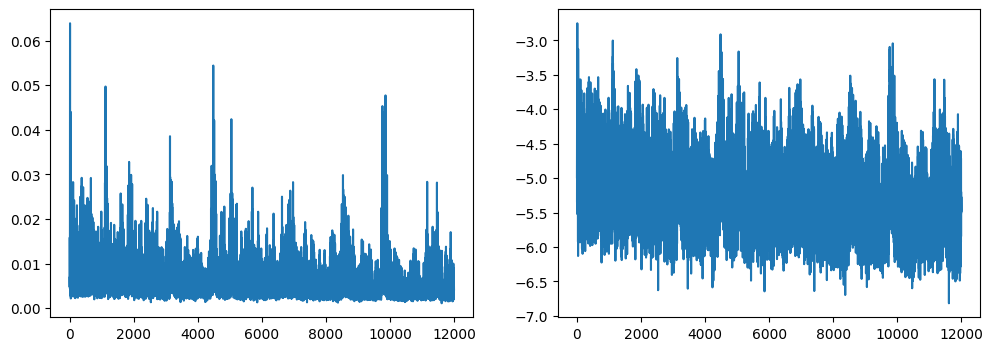

In [ ]:
if config.train:
  fig, axs = plt.subplots(1, 2, figsize=(12, 4))
  axs[0].plot(losses)
  axs[1].plot(np.log(losses))
  plt.show()

# Save model

In [ ]:
if config.save_model:
  model.save_pretrained(config.save_model_path)

In [ ]:
model.save_pretrained("./2DUnet-p8-111-ep400")

# Generate Sequence

In [ ]:
from diffusers import DDPMPipeline

emgseq_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [ ]:
def generate_sequences():
  pipeline_output = emgseq_pipe(batch_size=config.gen_batch_size,num_inference_steps=config.noise_scheduler_timesteps,output_type=np.array)
  gen_seqs = pipeline_output.images
  gen_seqs = gen_seqs.squeeze()
  print("shape: ", gen_seqs.shape)
  gen_seqs = np.transpose(gen_seqs, axes=(0,2,1))
  print("mean: ", np.mean(gen_seqs, axis=2))
  print("std: ", np.std(gen_seqs, axis=2))
  plot_emg_chunks(gen_seqs, nrows=config.nrows, ncols=config.ncols)
  return pipeline_output.images

  0%|          | 0/500 [00:00<?, ?it/s]

shape:  (9, 8, 256)
mean:  [[0.58105224 0.57967246 0.579568   ... 0.5780544  0.5779767  0.5786977 ]
 [0.6561998  0.65753454 0.6561382  ... 0.66715854 0.66625637 0.6693289 ]
 [0.61005795 0.6075281  0.6109244  ... 0.5814923  0.58551335 0.5856074 ]
 ...
 [0.5701422  0.56951755 0.56837445 ... 0.63880527 0.63883615 0.6401423 ]
 [0.607392   0.60315853 0.601977   ... 0.5991     0.59891874 0.60410833]
 [0.6130761  0.6112415  0.61241716 ... 0.5783215  0.57822114 0.57805485]]
std:  [[0.03474379 0.03397339 0.03319995 ... 0.03782342 0.03803874 0.03850375]
 [0.06159999 0.06718121 0.06587067 ... 0.07631968 0.07605118 0.07803991]
 [0.04831263 0.04588814 0.04956775 ... 0.03132743 0.03468854 0.03590694]
 ...
 [0.0277053  0.02785096 0.0272982  ... 0.06947822 0.06951704 0.07215577]
 [0.0466008  0.04395098 0.04348354 ... 0.04857529 0.04853247 0.04902745]
 [0.05477436 0.05085695 0.05176456 ... 0.0319613  0.03177993 0.03222133]]


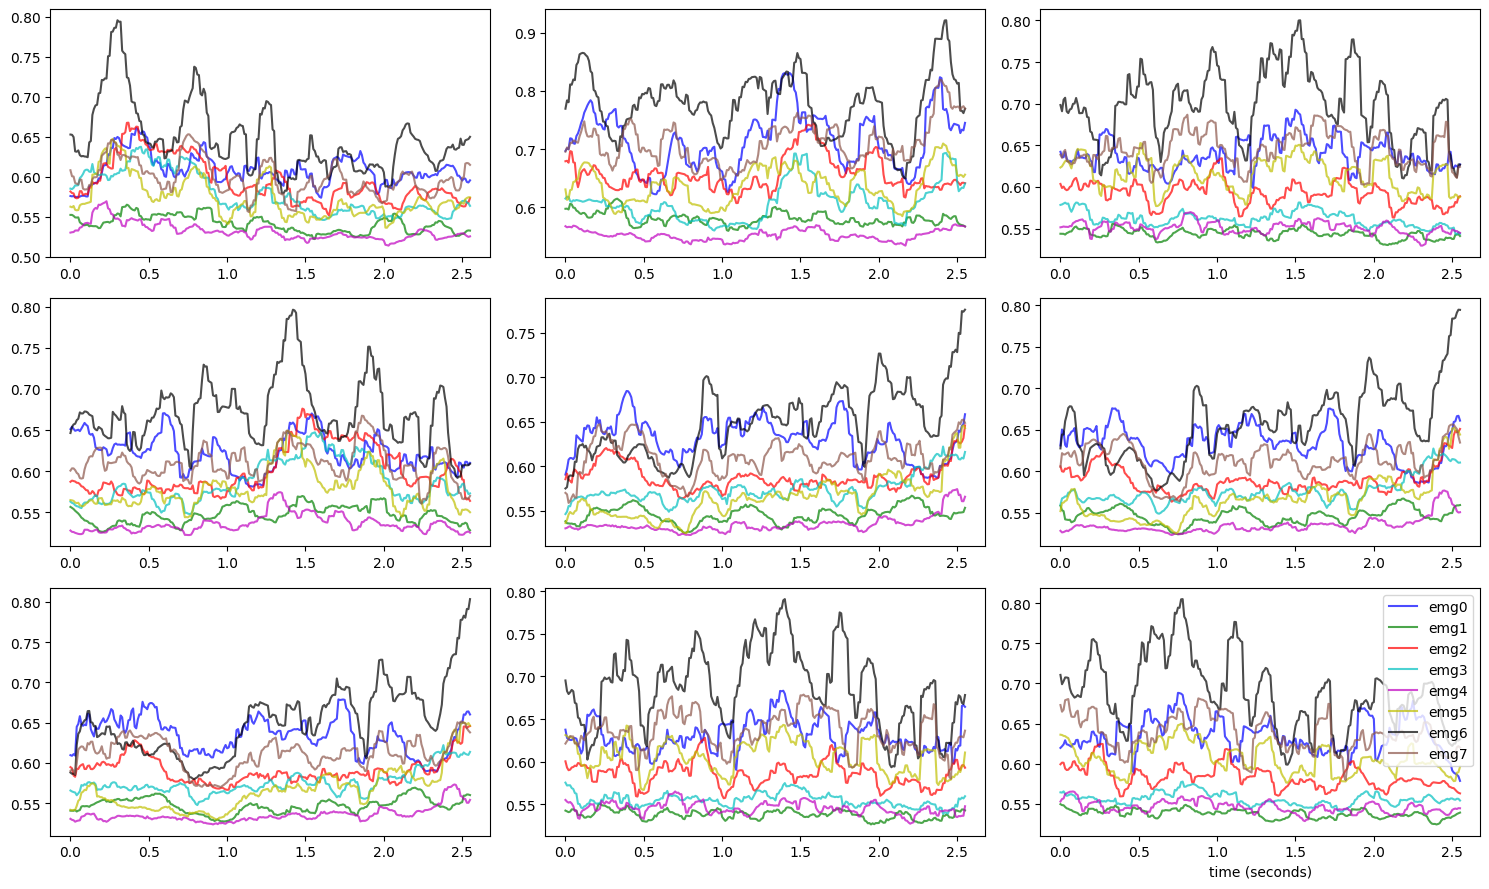

In [ ]:
output = generate_sequences()

In [ ]:
def deterministic_generate_sequences(this_model):
  deterministic_generator = torch.Generator()
  deterministic_generator.manual_seed(42)
  emgseq_pipe = DDPMPipeline(unet=this_model, scheduler=noise_scheduler)
  pipeline_output = emgseq_pipe(batch_size=config.gen_batch_size,num_inference_steps=config.noise_scheduler_timesteps,output_type=np.array,generator=deterministic_generator)
  gen_seqs = pipeline_output.images
  gen_seqs = gen_seqs.squeeze()
  print("shape: ", gen_seqs.shape)
  gen_seqs = np.transpose(gen_seqs, axes=(0,2,1))
  print("mean: ", np.mean(gen_seqs, axis=2))
  print("std: ", np.std(gen_seqs, axis=2))
  plot_emg_chunks(gen_seqs, nrows=config.nrows, ncols=config.ncols)
  return pipeline_output.images

  0%|          | 0/500 [00:00<?, ?it/s]

shape:  (9, 8, 256)
mean:  [[0.5932328  0.5931031  0.59334564 ... 0.5744922  0.57346135 0.57308716]
 [0.6060643  0.6137817  0.61320907 ... 0.5995182  0.6012419  0.59934795]
 [0.5899725  0.59021044 0.5913041  ... 0.573398   0.57167965 0.57050633]
 ...
 [0.5893963  0.59332263 0.59277046 ... 0.6059406  0.6135086  0.61318785]
 [0.6412318  0.63587296 0.6344563  ... 0.69613063 0.6968256  0.6949775 ]
 [0.5958574  0.59966093 0.5986252  ... 0.5776608  0.5774882  0.5791397 ]]
std:  [[0.03988663 0.04173497 0.04165239 ... 0.02867711 0.02752516 0.02918789]
 [0.05282269 0.0581051  0.05787493 ... 0.04940022 0.05180683 0.05265318]
 [0.03640572 0.0360287  0.03735858 ... 0.03004583 0.02957644 0.02908689]
 ...
 [0.04525468 0.04845272 0.04859991 ... 0.05452188 0.06106912 0.06114987]
 [0.07416658 0.0721366  0.07069356 ... 0.09379753 0.09523892 0.09637577]
 [0.04737402 0.05089831 0.05029824 ... 0.03516223 0.03587243 0.03581854]]


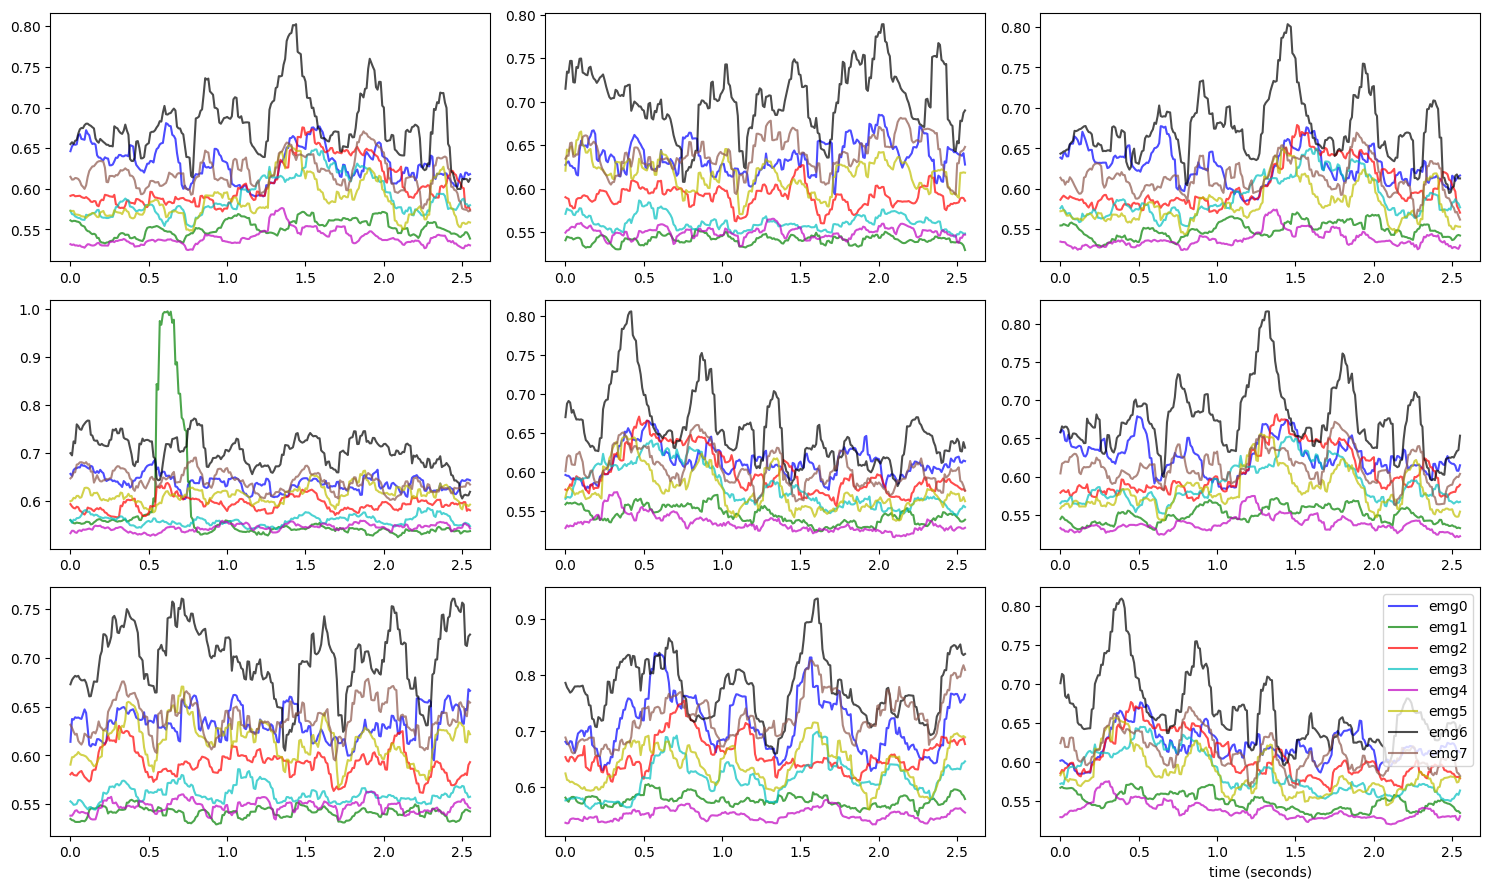

In [ ]:
output = deterministic_generate_sequences(model)


test

In [ ]:
!unzip 2Dunet-ep400.zip

Archive:  2Dunet-ep400.zip
   creating: 2Dunet-ep400/
  inflating: 2Dunet-ep400/config.json  
  inflating: 2Dunet-ep400/diffusion_pytorch_model.bin  


In [ ]:
p1_model = UNet2DModel.from_pretrained("/content/2Dunet-ep400").to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


  0%|          | 0/500 [00:00<?, ?it/s]

shape:  (9, 8, 256)
mean:  [[0.5535237  0.55260813 0.5519882  ... 0.57735    0.57810795 0.5780124 ]
 [0.4875382  0.49164802 0.4916727  ... 0.48340088 0.48729357 0.47990382]
 [0.29134312 0.32709113 0.32911164 ... 0.34565097 0.33611208 0.32617012]
 ...
 [0.3333542  0.35077834 0.35756826 ... 0.3685846  0.38688487 0.370376  ]
 [0.58790284 0.58700615 0.5833672  ... 0.6162481  0.6172536  0.6184821 ]
 [0.40062058 0.4222163  0.41071692 ... 0.4310339  0.43031645 0.41854754]]
std:  [[0.03393205 0.03397135 0.0347739  ... 0.0584297  0.05930107 0.05760417]
 [0.02094944 0.02035593 0.01968222 ... 0.01194939 0.01363839 0.01408464]
 [0.02617453 0.02795247 0.03145458 ... 0.04215405 0.03923879 0.03529184]
 ...
 [0.01943043 0.02935516 0.01389981 ... 0.04297549 0.03447369 0.0501128 ]
 [0.04436881 0.04566001 0.04423584 ... 0.07654046 0.07324071 0.06867556]
 [0.01639368 0.01348691 0.02137993 ... 0.03602168 0.04005128 0.04069309]]


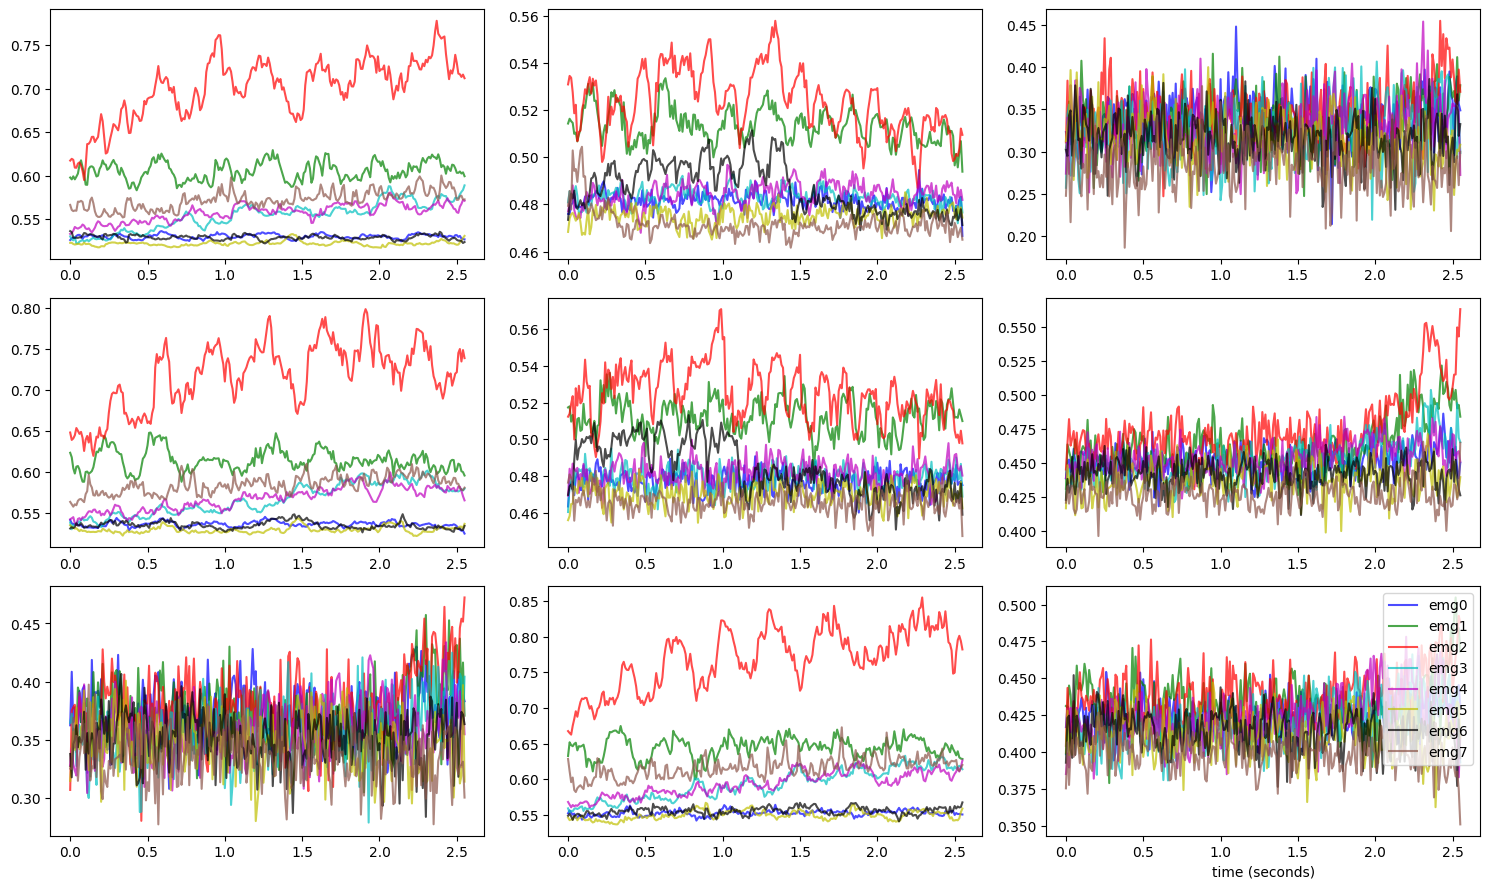

In [ ]:
output = deterministic_generate_sequences(p1_model)


In [ ]:
!unzip 2Dunet-ep200.zip

Archive:  2Dunet-ep200.zip
   creating: 2Dunet-ep200/
  inflating: 2Dunet-ep200/config.json  
  inflating: 2Dunet-ep200/diffusion_pytorch_model.bin  


In [ ]:
p1_200_model = UNet2DModel.from_pretrained("/content/2Dunet-ep200").to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


  0%|          | 0/500 [00:00<?, ?it/s]

shape:  (9, 8, 256)
mean:  [[0.58051866 0.5807439  0.5819102  ... 0.6106678  0.6115255  0.6200715 ]
 [0.54247296 0.5448876  0.54410243 ... 0.5636728  0.566882   0.56721824]
 [0.45179173 0.4540471  0.453839   ... 0.4574464  0.4499276  0.45270237]
 ...
 [0.45961225 0.46457475 0.4590722  ... 0.46521717 0.46761733 0.46574956]
 [0.6215536  0.63002133 0.6333288  ... 0.6776503  0.6817462  0.69552475]
 [0.50288874 0.50949824 0.50627214 ... 0.51319814 0.512779   0.5110007 ]]
std:  [[0.0350945  0.03631809 0.03947897 ... 0.06445209 0.06326715 0.05893662]
 [0.03170281 0.02996555 0.02838372 ... 0.05161576 0.05218104 0.0545712 ]
 [0.01141391 0.01302323 0.01005018 ... 0.01482018 0.01772921 0.01741064]
 ...
 [0.00706111 0.00967359 0.00882196 ... 0.01941133 0.01935841 0.02143479]
 [0.03558551 0.04163492 0.03638043 ... 0.07470214 0.07004746 0.06636   ]
 [0.01326092 0.0120746  0.01231655 ... 0.02310943 0.02492108 0.02463382]]


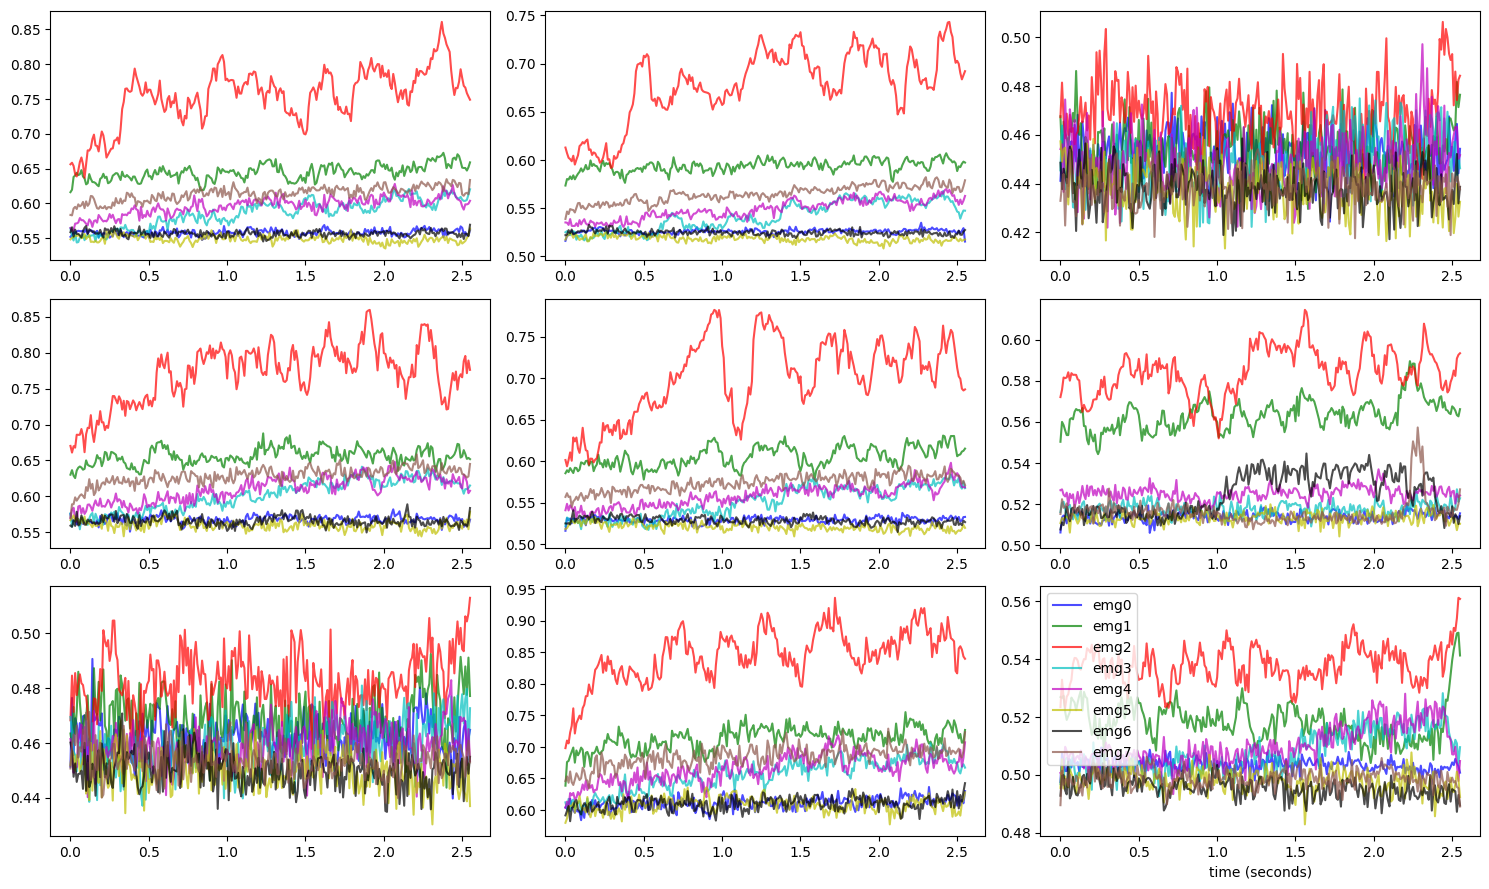

In [ ]:
output = deterministic_generate_sequences(p1_200_model)
